# Poisson process likelihood

Test case for a poisson process with a simple synthetic dataset of 1 dimensional events. 

The goal is to train a NN to predict intensity function for a uniformly sampled set of X's between 0 and 1.

TODO: train a scalable GP to do the same!

Reference: https://homepages.inf.ed.ac.uk/imurray2/pub/09poisson/adams-murray-mackay-2009b.pdf


In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

import torch
import math
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')

from torch import nn
from torch.distributions.poisson import Poisson
import tqdm
from mpl_toolkits.mplot3d import Axes3D

torch.manual_seed(0)

Populating the interactive namespace from numpy and matplotlib


Create 2 source distributions to sample from and graph them. All sampled events are 1 dimensional tensors whose values are in [0,1]. These events are our training set.

In [2]:
inputs_x = np.linspace(0, 1, 500)
inputs_y = np.linspace(0, 2*math.pi, 500)
num_samples = 50
samples1 = [np.random.beta(20, 70) for x in range(num_samples)]
samples2 = [np.random.beta(70, 20) for x in range(num_samples)]
all_samples = torch.tensor(samples1 + samples2)
print(all_samples.shape)

torch.Size([100])


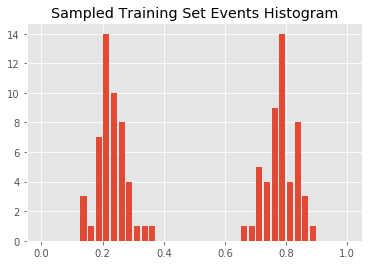

In [3]:
plt.title("Sampled Training Set Events Histogram")
p = plt.hist(all_samples, range=(0, 1), rwidth=0.8, bins=40)

In [4]:
all_samples

tensor([0.2753, 0.2188, 0.1852, 0.2196, 0.2442, 0.2804, 0.2559, 0.2643, 0.1927,
        0.2106, 0.2451, 0.3538, 0.1962, 0.2269, 0.2742, 0.1736, 0.2597, 0.2479,
        0.2484, 0.2238, 0.2125, 0.1882, 0.2155, 0.2092, 0.1818, 0.2623, 0.2917,
        0.2462, 0.1904, 0.1369, 0.2881, 0.2384, 0.1937, 0.2102, 0.2363, 0.2199,
        0.2236, 0.2217, 0.2638, 0.3430, 0.2705, 0.2543, 0.2185, 0.2281, 0.2096,
        0.2180, 0.2384, 0.3101, 0.1485, 0.1276, 0.8514, 0.7758, 0.7821, 0.8224,
        0.8165, 0.7223, 0.8278, 0.7994, 0.8389, 0.7526, 0.8777, 0.7846, 0.7861,
        0.7878, 0.7236, 0.7955, 0.7985, 0.8268, 0.8390, 0.7205, 0.8282, 0.7585,
        0.7357, 0.6837, 0.7437, 0.7888, 0.7238, 0.8639, 0.7512, 0.7935, 0.7653,
        0.7133, 0.8623, 0.8441, 0.7698, 0.8101, 0.8245, 0.7622, 0.7351, 0.7999,
        0.8348, 0.7545, 0.7718, 0.8450, 0.7837, 0.7443, 0.6682, 0.7657, 0.7893,
        0.7929])

In [5]:
from gpytorch.likelihoods import PoissonProcessLikelihood
from gpytorch.models import AbstractVariationalGP
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.means import ZeroMean, ConstantMean
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy, GridInterpolationVariationalStrategy
from gpytorch.distributions import MultivariateNormal

class PoissonProcessGPModel(AbstractVariationalGP):
    def __init__(self, train_x):
        variational_distribution = CholeskyVariationalDistribution(train_x.size(0))
        variational_strategy = GridInterpolationVariationalStrategy(self, 20, [(0., 1.)], variational_distribution)
        super(PoissonProcessGPModel, self).__init__(variational_strategy)
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = MultivariateNormal(mean_x, covar_x)
        return latent_pred


In [6]:
all_samples = all_samples.double()
x_grid = torch.linspace(0, 1, 20).double()
model = PoissonProcessGPModel(x_grid).double()

In [7]:
min_bounds = torch.tensor([0.]).double()
max_bounds = torch.tensor([1.]).double()
likelihood = PoissonProcessLikelihood(min_bounds, max_bounds).double()

In [8]:
model(all_samples)

MultivariateNormal(loc: torch.Size([100]))

In [9]:
model.variational_strategy.variational_distribution.variational_mean.data.copy_(torch.randn(x_grid.size(0)) * 0.1)

tensor([-0.1126, -0.1152, -0.0251, -0.0434,  0.0599, -0.1555, -0.0341,  0.1853,
         0.0468, -0.0158,  0.1444,  0.0266,  0.1389,  0.1586,  0.0946, -0.0844,
         0.0932,  0.1259,  0.2005,  0.0054], dtype=torch.float64)

In [10]:
sys.path.append('../../PyTorch-LBFGS/functions/')
from LBFGS import FullBatchLBFGS
from gpytorch.mlls.variational_elbo import VariationalELBO
import gpytorch

model.train()
likelihood.train()

optimizer = FullBatchLBFGS(model.parameters(), lr=1)
mll = VariationalELBO(likelihood, model, all_samples.numel())
def closure():
    optimizer.zero_grad()
    output = model(all_samples)
    loss = -mll.forward(output, all_samples, model=model)
    return loss

loss = closure()

training_iter = 30
for i in range(training_iter):

    # perform step and update curvature
    options = {'closure': closure, 'current_loss': loss, 'max_ls': 30, 'c1': 1e-4}
    with gpytorch.settings.max_preconditioner_size(15):
        loss, _, lr, _, F_eval, G_eval, _, _ = optimizer.step(options)

    print('Iter %d/%d - Loss: %.3f - LR: %.3f' % (
        i + 1, training_iter, loss.item(), lr
        ))


Iter 1/30 - Loss: 2.107 - LR: 0.002
Iter 2/30 - Loss: 1.645 - LR: 0.218
Iter 3/30 - Loss: 1.582 - LR: 1.000
Iter 4/30 - Loss: 1.294 - LR: 1.000
Iter 5/30 - Loss: 0.861 - LR: 1.000
Iter 6/30 - Loss: -0.250 - LR: 1.000
Iter 7/30 - Loss: -0.669 - LR: 0.477
Iter 8/30 - Loss: -0.794 - LR: 1.000
Iter 9/30 - Loss: -0.914 - LR: 1.000
Iter 10/30 - Loss: -1.074 - LR: 1.000
Iter 11/30 - Loss: -1.412 - LR: 1.000
Iter 12/30 - Loss: -1.676 - LR: 1.000
Iter 13/30 - Loss: -1.724 - LR: 0.200
Iter 14/30 - Loss: -1.801 - LR: 1.000
Iter 15/30 - Loss: -1.813 - LR: 0.455
Iter 16/30 - Loss: -1.877 - LR: 1.000
Iter 17/30 - Loss: -1.923 - LR: 1.000
Iter 18/30 - Loss: -1.981 - LR: 1.000
Iter 19/30 - Loss: -2.031 - LR: 1.000
Iter 20/30 - Loss: -2.036 - LR: 0.138
Iter 21/30 - Loss: -2.043 - LR: 1.000
Iter 22/30 - Loss: -2.075 - LR: 1.000
Iter 23/30 - Loss: -2.090 - LR: 0.500
Iter 24/30 - Loss: -2.094 - LR: 0.012
Iter 25/30 - Loss: -2.141 - LR: 1.000
Iter 26/30 - Loss: -2.148 - LR: 0.463
Iter 27/30 - Loss: -2.158 

In [11]:
from gpytorch.mlls.variational_elbo import VariationalELBO
import gpytorch

train_y = all_samples

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1, amsgrad=True)

# "Loss" for GPs - the marginal log likelihood
# num_data refers to the amount of training data
mll = VariationalELBO(likelihood, model, all_samples.numel())

training_iter = 500
for i in range(training_iter):
    # Zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # Get predictive output
    with gpytorch.settings.max_preconditioner_size(15):
        output = model(all_samples)
        # Calc loss and backprop gradients
        loss = -mll.forward(output, all_samples, model=model)
        loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
    optimizer.step()

Iter 1/500 - Loss: -2.173
Iter 2/500 - Loss: -2.255
Iter 3/500 - Loss: -2.311
Iter 4/500 - Loss: -2.322
Iter 5/500 - Loss: -2.347
Iter 6/500 - Loss: -2.365
Iter 7/500 - Loss: -2.368
Iter 8/500 - Loss: -2.424
Iter 9/500 - Loss: -2.391
Iter 10/500 - Loss: -2.440
Iter 11/500 - Loss: -2.440
Iter 12/500 - Loss: -2.430
Iter 13/500 - Loss: -2.443
Iter 14/500 - Loss: -2.446
Iter 15/500 - Loss: -2.435
Iter 16/500 - Loss: -2.488
Iter 17/500 - Loss: -2.543
Iter 18/500 - Loss: -2.529
Iter 19/500 - Loss: -2.486
Iter 20/500 - Loss: -2.514
Iter 21/500 - Loss: -2.524
Iter 22/500 - Loss: -2.527
Iter 23/500 - Loss: -2.543
Iter 24/500 - Loss: -2.557
Iter 25/500 - Loss: -2.541
Iter 26/500 - Loss: -2.550
Iter 27/500 - Loss: -2.536
Iter 28/500 - Loss: -2.551
Iter 29/500 - Loss: -2.590
Iter 30/500 - Loss: -2.558
Iter 31/500 - Loss: -2.545
Iter 32/500 - Loss: -2.531
Iter 33/500 - Loss: -2.588
Iter 34/500 - Loss: -2.603
Iter 35/500 - Loss: -2.596
Iter 36/500 - Loss: -2.565
Iter 37/500 - Loss: -2.630
Iter 38/50

Iter 308/500 - Loss: -3.988
Iter 309/500 - Loss: -3.962
Iter 310/500 - Loss: -3.978
Iter 311/500 - Loss: -3.963
Iter 312/500 - Loss: -3.991
Iter 313/500 - Loss: -4.006
Iter 314/500 - Loss: -4.028
Iter 315/500 - Loss: -3.963
Iter 316/500 - Loss: -3.962
Iter 317/500 - Loss: -3.984
Iter 318/500 - Loss: -3.964
Iter 319/500 - Loss: -3.970
Iter 320/500 - Loss: -4.028
Iter 321/500 - Loss: -4.012
Iter 322/500 - Loss: -4.015
Iter 323/500 - Loss: -4.000
Iter 324/500 - Loss: -3.998
Iter 325/500 - Loss: -3.972
Iter 326/500 - Loss: -4.033
Iter 327/500 - Loss: -4.076
Iter 328/500 - Loss: -4.021
Iter 329/500 - Loss: -4.046
Iter 330/500 - Loss: -4.023
Iter 331/500 - Loss: -4.016
Iter 332/500 - Loss: -4.049
Iter 333/500 - Loss: -4.022
Iter 334/500 - Loss: -4.052
Iter 335/500 - Loss: -4.008
Iter 336/500 - Loss: -4.000
Iter 337/500 - Loss: -4.028
Iter 338/500 - Loss: -4.019
Iter 339/500 - Loss: -4.014
Iter 340/500 - Loss: -4.070
Iter 341/500 - Loss: -4.001
Iter 342/500 - Loss: -4.041
Iter 343/500 - Loss:

In [12]:
import gpytorch

model.eval()
x_grid_dense = torch.linspace(0, 1, 100).double()
with gpytorch.settings.max_preconditioner_size(15):
    preds = model(x_grid_dense)
std = preds.variance.sqrt()
lower = preds.mean.pow(2) - std
upper = preds.mean.pow(2) + std

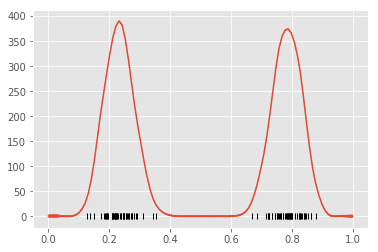

In [14]:
plt.plot(x_grid_dense.numpy(), preds.mean.pow(2).detach().numpy())
plt.fill_between(x_grid_dense, lower.detach().numpy(), upper.detach().numpy())
plt.plot(all_samples.numpy(), np.zeros(all_samples.size(-1)), 'k|')